### Plot T and S CASE STSE output around SVB

In [1]:
import cmocean as cmo
import datetime as dt
import matplotlib.animation as animation
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy as sc
import scipy.io as sio
from matplotlib.gridspec import GridSpec
import seawater as sw
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def read_bin(file, shape, k=0, dtype='>f4'):
    '''Read the whole binary file
    shape:: tuple with the final shape of the 
            data in order (nt,ny,nx,nz) for 
            3D + time fields or (nt,ny,nx) for 
            2D + time fields.
    dtype:: string with any accepted python format. 
            Most common are '>f8' equivalent to real*8, 
            ieee-b and '>f4' equivalent to real*4, ieee-b.
    RETURNS
    Numpy array of data of shape "shape".
    '''
#    with open(file, 'r') as f:
#        cc = np.fromfile(f,dtype=dtype)
#   return(np.reshape(cc, shape, order='C'))
    shape_arr = np.array(shape)
    nnn = shape_arr.prod()
    WORDLENGTH = 4 # default word length
    with open(file, "rb") as f:
        if k=='all': # Load the whole thing
            cc=np.fromfile(f,dtype=dtype)
        else:
            offs=nnn*k*WORDLENGTH
            #f.seek(nnn*k*WORDLENGTH)
            cc=np.fromfile(f,offset=offs,count=nnn,dtype=dtype)
    return(np.reshape(cc, shape, order='C'))


def load_bat(file):
    '''Load X, Y and Z arrays from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['XC'][:], bathy['YC'][:], bathy['RC'][:])

def load_depth(file):
    '''Load depth array from mat file'''
    bathy = sio.loadmat(bathy_file)
    return(bathy['Depth'][:])

def matlab2datetime(matlab_datenum):
    day = dt.datetime.fromordinal(int(matlab_datenum))
    dayfrac = dt.timedelta(days=matlab_datenum%1) - dt.timedelta(days = 366)
    return day + dayfrac

def plot_fld(ax,XC,YC,fld_slice,date_str, vmin=-0.15, vmax=0.15, cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],fld_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.025, 0.76])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_vel(ax,XC,YC,v_slice,date_str, vmin=-0.8, vmax=0.8):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],v_slice, cmap=cmo.cm.balance, vmin=vmin, vmax=vmax)
    cb = plt.colorbar(pc, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    return(ax)

def plot_fld_anim(ax,XC,YC,eta_slice,date_str,vmin=-0.15, vmax=0.15,cmap=cmo.cm.balance,clab=r'Free surface (m)'):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[:,0],YC[0,:],eta_slice, cmap=cmap, vmin=vmin, vmax=vmax)
    cmap = cmap
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cbar_ax = fig.add_axes([0.89, 0.125, 0.022, 0.755])
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
                      cax=cbar_ax, orientation='vertical', 
                      format='%1.2f', label=clab)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-59,0]
    height = YC[0,59]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=2,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    return(ax)

def plot_fld_zoom(ax,XC,YC,eta_slice,date_str,vmin=-0.15,vmax=0.15,cmap=cmo.cm.balance):
    ax.set_facecolor('tan')
    pc = ax.pcolormesh(XC[-60:,0],YC[0,:60],eta_slice[:60,-60:], cmap=cmap, vmin=vmin, vmax=vmax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(matlab2datetime(date_str))
    ax.set_aspect(1)
    width = XC[-1,0]-XC[-60,0]
    height = YC[0,60]-YC[0,0]
    rect = patches.Rectangle((XC[-60,0],YC[0,0]),width,height,linewidth=3,edgecolor='k', facecolor='none')
    ax.add_patch(rect)
    ax.set_xlim(XC[-60,0],XC[-1,0],)
    ax.set_ylim(YC[0,0],YC[0,60],)
    
    return(ax)



In [3]:
bathy_file = '/Volumes/MOBY/CASE-CCS/full_domain/grid.mat'
fmt_file = '/Volumes/MOBY/CASE-CCS/full_domain/FMT.mat'

fpath = '/Volumes/MOBY/CASE-CCS/full_domain/'
dpath = '/Volumes/MOBY/CASE-CCS/full_domain/'

In [4]:
XC, YC, ZC = load_bat(bathy_file)
depth = load_depth(bathy_file)
nxc = len(XC[:])
nyc = len(YC[0,:]) 
nzc = len(ZC[:])
nt = 4656

In [5]:
# Read date strings
date_strs = read_bin(dpath+'TIME_CCS_2007_2019.bin', (nt), k=0)

tt1 = 32+365
# Read T
T1 = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt1)
# Read S
S1 = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt1)

tt2 = (31*7)+365
# Read T
T2 = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt2)
# Read S
S2 = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt2)

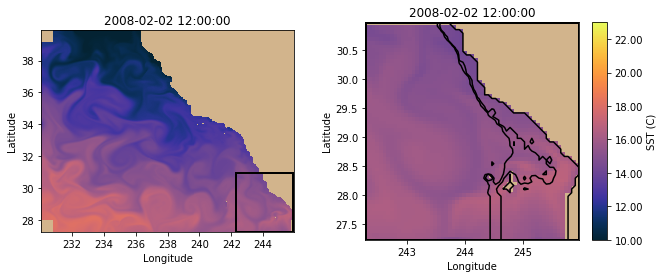

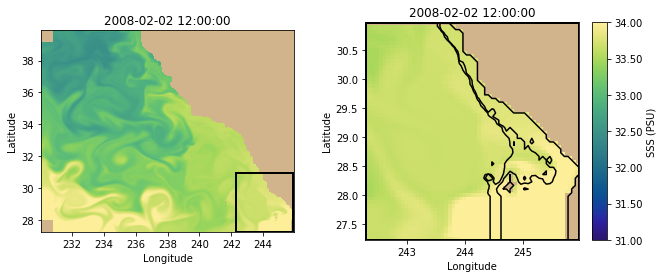

In [6]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,T1[0,:,:],date_strs[tt1],vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='SST (C)')
plot_fld_zoom(ax1,XC,YC,T1[0,:,:],date_strs[tt1],vmin=10,vmax=23,cmap=cmo.cm.thermal)
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')
plt.show()

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,S1[0,:,:],date_strs[tt1],vmin=31,vmax=34,cmap=cmo.cm.haline,clab='SSS (PSU)')
plot_fld_zoom(ax1,XC,YC,S1[0,:,:],date_strs[tt1],vmin=31,vmax=34,cmap=cmo.cm.haline)
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')


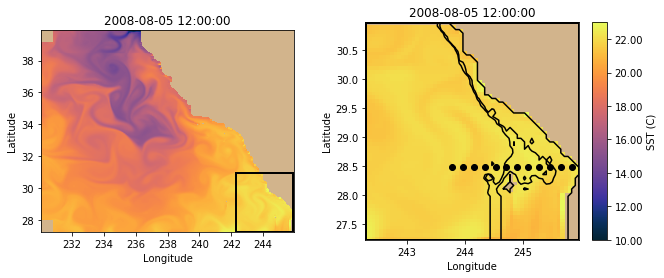

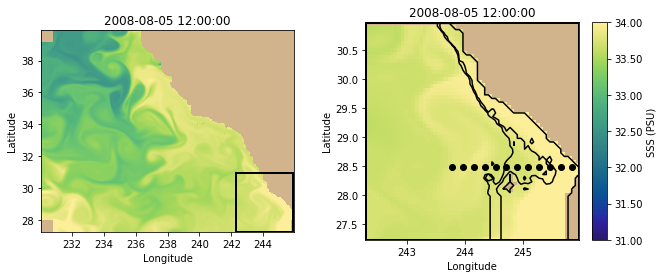

In [9]:
fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,T2[0,:,:],date_strs[tt2],vmin=10,vmax=23,cmap=cmo.cm.thermal,clab='SST (C)')
plot_fld_zoom(ax1,XC,YC,T2[0,:,:],date_strs[tt2],vmin=10,vmax=23,cmap=cmo.cm.thermal)
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')
ax1.plot(XC[220::3,20],YC[220::3,20],'ko')

plt.show()

fig, (ax0,ax1) = plt.subplots(1,2, figsize=(10,4)) 

plot_fld_anim(ax0,XC,YC,S2[0,:,:],date_strs[tt2],vmin=31,vmax=34,cmap=cmo.cm.haline,clab='SSS (PSU)')
plot_fld_zoom(ax1,XC,YC,S2[0,:,:],date_strs[tt2],vmin=31,vmax=34,cmap=cmo.cm.haline)
ax1.plot(XC[220::3,20],YC[220::3,20],'ko')
cn = ax1.contour(XC,YC,depth, levels=[0,100,200], colors='k')


T, S and density profiles along 28.5 N


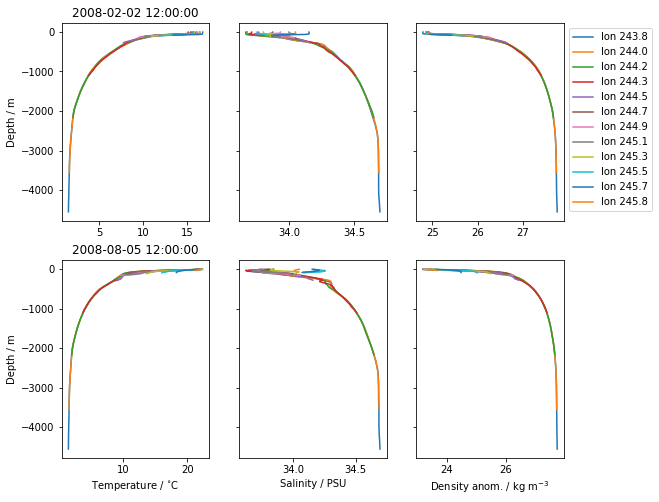

In [10]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize=(9,8), sharey=True) 

for ii in range(220,256,3):
    ax0.plot(T1[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    ax3.plot(T2[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    
    ax1.plot(S1[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    ax4.plot(S2[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    
    dens1 = sw.pden(np.squeeze(S1[:,20,ii]),np.squeeze(T1[:,20,ii]),np.squeeze(ZC[:]))
    ax2.plot(dens1-1000,ZC[:],label='lon %1.1f'%XC[ii,20])

    dens2 = sw.pden(np.squeeze(S2[:,20,ii]),np.squeeze(T2[:,20,ii]),np.squeeze(ZC[:]))
    ax5.plot(dens2-1000,ZC[:],label='lon %1.1f'%XC[ii,20])

ax2.legend(bbox_to_anchor=(1,1))  
ax0.set_title(matlab2datetime(date_strs[tt1]))
ax3.set_title(matlab2datetime(date_strs[tt2]))
ax0.set_ylabel('Depth / m')
ax3.set_ylabel('Depth / m')
ax3.set_xlabel(r'Temperature / $^{\circ}$C')
ax4.set_xlabel(r'Salinity / PSU')
ax5.set_xlabel(r'Density anom. / kg m$^{-3}$')

#ax0.set_ylim(-200,0)
print('T, S and density profiles along 28.5 N')

T, S and density profiles along 28.5 N above 200 m


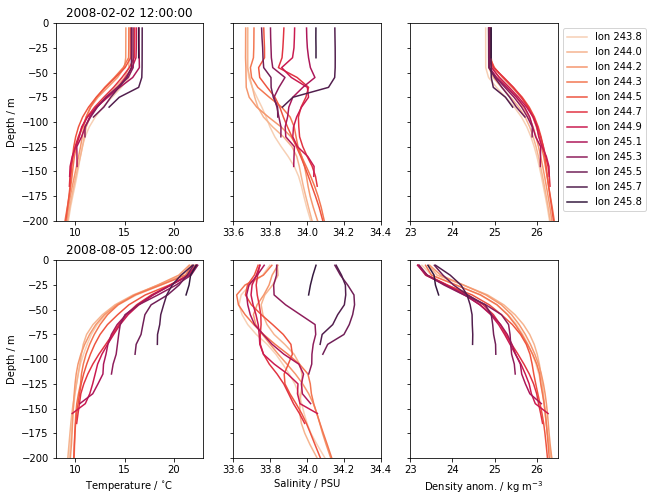

In [13]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize=(9,8), sharey=True) 
sns.set_palette("rocket_r",13)
for ii in range(220,256,3):
    ax0.plot(T1[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    ax3.plot(T2[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])

    ax1.plot(S1[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])
    ax4.plot(S2[:,20,ii],ZC[:],label='lon %1.1f'%XC[ii,20])

    dens1 = sw.pden(np.squeeze(S1[:,20,ii]),np.squeeze(T1[:,20,ii]),np.squeeze(ZC[:]))
    ax2.plot(dens1-1000,ZC[:],label='lon %1.1f'%XC[ii,20])

    dens2 = sw.pden(np.squeeze(S2[:,20,ii]),np.squeeze(T2[:,20,ii]),np.squeeze(ZC[:]))
    ax5.plot(dens2-1000,ZC[:],label='lon %1.1f'%XC[ii,20])

ax2.legend(bbox_to_anchor=(1,1))  
ax0.set_title(matlab2datetime(date_strs[tt1]))
ax3.set_title(matlab2datetime(date_strs[tt2]))
ax0.set_ylabel('Depth / m')
ax3.set_ylabel('Depth / m')
ax3.set_xlabel(r'Temperature / $^{\circ}$C')
ax4.set_xlabel(r'Salinity / PSU')
ax5.set_xlabel(r'Density anom. / kg m$^{-3}$')

ax0.set_xlim(8,23)
ax3.set_xlim(8,23)
ax1.set_xlim(33.6,34.4)
ax4.set_xlim(33.6,34.4)
ax2.set_xlim(23,26.5)
ax5.set_xlim(23,26.5)

ax0.set_ylim(-200,0)
print('T, S and density profiles along 28.5 N above 200 m')

### Mean T, S and Rho profiles during  January-February and July-August 2008

In [15]:
winter_ind = [365,365+60] # Jan and Feb
summer_ind = [365+183,365+183+62] # Jul and Aug

summer_T = np.empty((12,nzc,summer_ind[1]-summer_ind[0])) # 9 stations, nzc depth levels, 62 days
summer_S = np.empty_like(summer_T)
summer_Rho = np.empty_like(summer_T)

winter_T = np.empty((12,nzc, winter_ind[1]-winter_ind[0])) # 9 stations, nzc depth levels, 60 days
winter_S = np.empty_like(winter_T)
winter_Rho = np.empty_like(winter_T)

ii = 0
for tt in range(winter_ind[0], winter_ind[1]): # loop through days
    T = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    S = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    jj = 0
    for kk in range(220,256,3): # loop through stations
        winter_T[jj,:,ii] = T[:,20,kk]
        winter_S[jj,:,ii] = S[:,20,kk]
        winter_Rho[jj,:,ii] = sw.pden(np.squeeze(S[:,20,kk]),np.squeeze(T[:,20,kk]),np.squeeze(ZC[:]))
        jj = jj+1
    ii = ii+1
    #print(ii)

In [16]:
ii = 0
for tt in range(summer_ind[0], summer_ind[1]): # loop through days
    T = read_bin(dpath+'T_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    S = read_bin(dpath+'S_MIT_CCS_2007_2019_fulldomain.bin', (nzc,nyc,nxc), k=tt)
    jj = 0
    for kk in range(230,256,3): # loop through stations
        summer_T[jj,:,ii] = T[:,20,kk]
        summer_S[jj,:,ii] = S[:,20,kk]
        summer_Rho[jj,:,ii] = sw.pden(np.squeeze(S[:,20,kk]),np.squeeze(T[:,20,kk]),np.squeeze(ZC[:]))
        jj = jj+1
    ii = ii+1
    #print(ii)

Mean T, S and density profiles along 28.5 N above 200 m


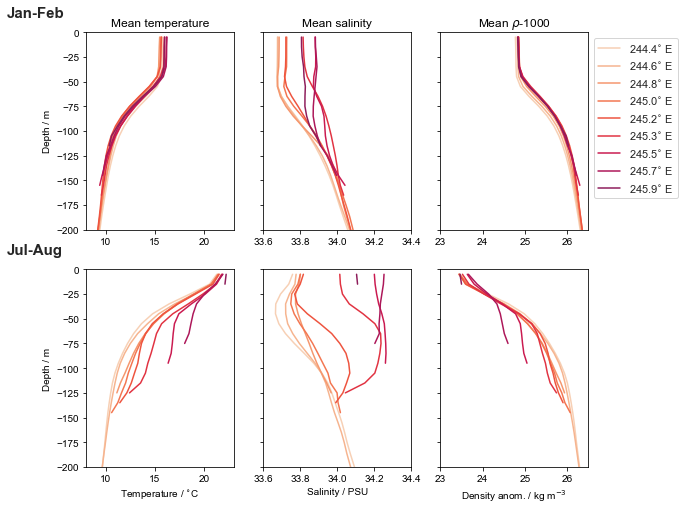

In [17]:
fig, ((ax0,ax1,ax2),(ax3,ax4,ax5)) = plt.subplots(2,3, figsize=(9,8), sharey=True) 
sns.set_palette("rocket_r",12)
sns.set_style('whitegrid')
sns.set_context('notebook')
for ii, mm in zip(range(9),range(230,256,3)):
    ax0.plot(np.nanmean(winter_T[ii,:,:], axis=1),ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])
    ax3.plot(np.nanmean(summer_T[ii,:,:], axis=1),ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])
    ax1.plot(np.nanmean(winter_S[ii,:,:], axis=1),ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])
    ax4.plot(np.nanmean(summer_S[ii,:,:], axis=1),ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])
    ax2.plot(np.nanmean(winter_Rho[ii,:,:], axis=1)-1000,ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])
    ax5.plot(np.nanmean(summer_Rho[ii,:,:], axis=1)-1000,ZC[:],label='%1.1f$^{\circ}$ E'%XC[mm,20])

   
ax2.legend(bbox_to_anchor=(1,1))  
ax0.text(0,15,'Jan-Feb', weight='bold',fontsize=15)
ax3.text(0,15,'Jul-Aug', weight='bold',fontsize=15)
ax0.set_ylabel('Depth / m')
ax3.set_ylabel('Depth / m')
ax3.set_xlabel(r'Temperature / $^{\circ}$C')
ax4.set_xlabel(r'Salinity / PSU')
ax5.set_xlabel(r'Density anom. / kg m$^{-3}$')

ax0.set_title('Mean temperature')
ax1.set_title('Mean salinity')
ax2.set_title(r'Mean $\rho$-1000')
ax0.set_xlim(8,23)
ax3.set_xlim(8,23)
ax1.set_xlim(33.6,34.4)
ax4.set_xlim(33.6,34.4)
ax2.set_xlim(23,26.5)
ax5.set_xlim(23,26.5)

ax0.set_ylim(-200,0)
print('Mean T, S and density profiles along 28.5 N above 200 m')

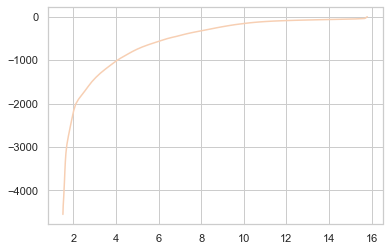

In [18]:
plt.plot(np.nanmean(winter_T[0,:,:], axis=1),ZC)


In my coarse model there are 15 equally-spaced z-levels except for the deepest one, and the max depth is 1000 m  $\Delta$z=66.5 m up to the last level for which $\Delta z$ with is 69.0
    


In [19]:
z_model = np.zeros(16)
for ii in range(1,15):
    z_model[ii] = -66.5*ii
z_model[15] = -1000.0

In [20]:
# Interpolate T and S into z_model

winT_func = sc.interpolate.interp1d(np.squeeze(ZC),np.nanmean(winter_T[0,:,:], axis=1),fill_value='extrapolate')
win_T = winT_func(z_model)
winS_func = sc.interpolate.interp1d(np.squeeze(ZC),np.nanmean(winter_S[0,:,:], axis=1),fill_value='extrapolate')
win_S = winS_func(z_model)

sumT_func = sc.interpolate.interp1d(np.squeeze(ZC),np.nanmean(summer_T[0,:,:], axis=1),fill_value='extrapolate')
sum_T = sumT_func(z_model)
sumS_func = sc.interpolate.interp1d(np.squeeze(ZC),np.nanmean(summer_S[0,:,:], axis=1),fill_value='extrapolate')
sum_S = sumS_func(z_model)

In [21]:
print(np.nanmean(winter_T[0,:,:], axis=1))
print(np.nanmean(winter_S[0,:,:], axis=1))
print(np.nanmean(summer_T[0,:,:], axis=1))
print(np.nanmean(summer_S[0,:,:], axis=1))


[15.79664887 15.7600372  15.7379595  15.7219097  15.65838076 15.25330957
 14.38692344 13.40568368 12.54543626 11.87876372 11.38595885 11.01621146
 10.72449576 10.48387567 10.278288   10.09800415  9.9327819   9.77062659
  9.5971034   9.39576468  9.16622227  8.93222044  8.71294785  8.50692177
  8.30172629  8.09034558  7.87583205  7.66729462  7.47185598  7.29224937
  7.12757097  6.96995717  6.80810343  6.62843897  6.41067795  6.13467185
  5.81839395  5.51018476  5.23369647  4.99605322  4.78818682  4.60159867
  4.42349842  4.24099244  4.03760279  3.79409839  3.52416543  3.27270665
  3.05452256  2.86563205  2.70658993  2.55612723  2.3993378   2.24272082
  2.10856194  2.01380725  1.9313506   1.84656628  1.76475865  1.69266158
  1.64764772  1.62005997  1.60060617  1.58378614  1.56479926  1.54538419
  1.52130724  1.50793121         nan         nan         nan         nan]
[33.67694041 33.67669907 33.6762661  33.67582741 33.67431965 33.67612801
 33.69741198 33.73369274 33.77484074 33.81401641 3

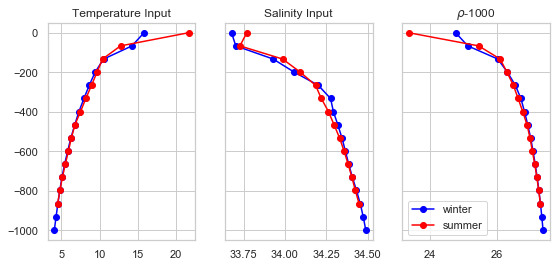

In [22]:
fig, (ax0,ax1,ax2) = plt.subplots(1,3, figsize=(9,4), sharey=True) 
ax0.plot(win_T,z_model,'bo-', label='winter')
ax1.plot(win_S,z_model,'bo-',label='winter')
ax2.plot(sw.pden(win_S,win_T,z_model)-1000,z_model,'bo-',label='winter')
ax0.plot(sum_T,z_model,'ro-',label='summer')
ax1.plot(sum_S,z_model,'ro-',label='summer')
ax2.plot(sw.pden(sum_S,sum_T,z_model)-1000,z_model,'ro-',label='summer')
ax0.set_title('Temperature Input')
ax1.set_title('Salinity Input')
ax2.set_title(r'$\rho$-1000')
ax2.legend()


Fix NaN's:

In [23]:
sum_T

array([21.64682876, 12.74675908, 10.38874599,  9.6727914 ,  8.94932483,
        8.20773505,  7.5051748 ,  6.78419588,  6.30917936,  5.92973521,
        5.52044952,  5.1386131 ,  4.81229302,  4.51353765,         nan,
               nan])

In [24]:
sum_S

array([33.76952433, 33.72766582, 33.9860661 , 34.0933517 , 34.18564079,
       34.22028464, 34.26373605, 34.29737469, 34.33078381, 34.35812137,
       34.38275788, 34.40535458, 34.42640472, 34.44870821,         nan,
               nan])

In [25]:
win_T

array([15.8149547 , 14.23973748, 10.53199969,  9.4192542 ,  8.65114002,
        7.95627462,  7.3012297 ,  6.75869571,  6.25156855,  5.82788229,
        5.42723828,  5.08398122,  4.79650148,  4.54994959,  4.31034471,
        4.07828072])

In [26]:
win_S

array([33.67706108, 33.7028541 , 33.92904419, 34.05672789, 34.20219033,
       34.2762218 , 34.29350054, 34.31998064, 34.3452226 , 34.36600468,
       34.38619758, 34.40847429, 34.43324581, 34.45583045, 34.47414151,
       34.48963983])

## For 36 depth levels model

In [27]:
z_model = np.zeros(16)
for ii in range(1,15):
    z_model[ii] = -66.5*ii
z_model[15] = -1000.0

In [28]:
len(ZC)

72

In [29]:
for zz in ZC:
    print(zz)

[-5.]
[-15.]
[-25.]
[-35.]
[-45.]
[-55.]
[-65.]
[-75.]
[-85.]
[-95.]
[-105.]
[-115.]
[-125.]
[-135.]
[-145.]
[-155.]
[-165.]
[-175.]
[-186.25]
[-201.25]
[-220.]
[-240.]
[-260.]
[-280.]
[-300.]
[-320.]
[-340.]
[-360.]
[-380.]
[-400.]
[-420.]
[-440.]
[-460.]
[-480.]
[-507.5]
[-550.]
[-600.]
[-650.]
[-700.]
[-750.]
[-800.]
[-850.]
[-900.]
[-950.]
[-1012.5]
[-1100.]
[-1200.]
[-1300.]
[-1400.]
[-1500.]
[-1600.]
[-1700.]
[-1800.]
[-1900.]
[-2012.5]
[-2162.5]
[-2350.]
[-2550.]
[-2750.]
[-2950.]
[-3150.]
[-3350.]
[-3550.]
[-3750.]
[-3950.]
[-4150.]
[-4350.]
[-4550.]
[-4750.]
[-4950.]
[-5150.]
[-5350.]
